# Analyse der Klima-Komposita auf deutschsprachigen Titelseiten

**Forschungsfrage**: Wie hat sich die Verwendung der häufigsten Begriffe mit dem Wortstamm 'Klima' auf deutschsprachigen Online-Titelseiten zwischen 2021 und 2025 entwickelt?

**Zeitraum**: Ab 21.04.2022 (Scraper-Wechsel, konsistente Datenbasis)

**Drei Begriffe**: Klimaschutz, Klimawandel, Klimakrise

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Pfade
BASE_PATH = os.path.dirname(os.getcwd())
DATA_OUTPUT = os.path.join(BASE_PATH, 'data_output')

# Daten laden
df_context = pd.read_csv(os.path.join(DATA_OUTPUT, 'dwh_context_full.csv'))
df_meta = pd.read_csv(os.path.join(DATA_OUTPUT, 'dwh_meta_full.csv'))

print(f"Context-Daten: {len(df_context)} Zeilen")
print(f"Meta-Daten: {len(df_meta)} Zeilen")

Context-Daten: 191638 Zeilen
Meta-Daten: 77673 Zeilen


In [2]:
# Daten zusammenführen (Context + Meta via newspaper_id)
df = df_context.merge(df_meta[['newspaper_id', 'data_published']], on='newspaper_id', how='left')

# Datum konvertieren
df['date'] = pd.to_datetime(df['data_published'])

# Filter: Ab 21.04.2022 (Scraper-Wechsel)
SCRAPER_CUTOFF = '2022-04-21'
df = df[df['date'] >= SCRAPER_CUTOFF]

print(f"Daten ab {SCRAPER_CUTOFF}: {len(df)} Nennungen")
print(f"Zeitraum: {df['date'].min()} bis {df['date'].max()}")

Daten ab 2022-04-21: 139140 Nennungen
Zeitraum: 2022-04-21 00:00:00 bis 2025-01-31 00:00:00


In [3]:
# Suffix normalisieren (Kleinschreibung) und drei Begriffe definieren
df['suffix_clean'] = df['suffix'].str.lower().str.strip()

# Mapping: Suffixe zu Begriffen
# Klimawandel: wandel, wandels (Genitiv)
# Klimakrise: krise
# Klimaschutz: schutz, schutzes, schützern, etc.

def map_to_begriff(suffix):
    if pd.isna(suffix):
        return None
    suffix = suffix.lower().strip()
    if suffix in ['wandel', 'wandels']:
        return 'Klimawandel'
    elif suffix in ['krise']:
        return 'Klimakrise'
    elif suffix.startswith('schutz'):
        return 'Klimaschutz'
    return None

df['begriff'] = df['suffix_clean'].apply(map_to_begriff)

# Nur die drei Begriffe behalten
df_drei = df[df['begriff'].notna()].copy()

print(f"Nennungen der drei Begriffe: {len(df_drei)}")
print(df_drei['begriff'].value_counts())

Nennungen der drei Begriffe: 46785
begriff
Klimawandel    21542
Klimaschutz    14663
Klimakrise     10580
Name: count, dtype: int64


## Analyse 1: Gesamtverteilung der Begriffe

In [4]:
# Absolute Häufigkeiten
counts = df_drei['begriff'].value_counts()
total = counts.sum()

# Relative Häufigkeiten
percentages = (counts / total * 100).round(2)

# Tabelle erstellen
gesamtverteilung = pd.DataFrame({
    'Begriff': counts.index,
    'Absolute Häufigkeit': counts.values,
    'Relative Häufigkeit (%)': percentages.values
})
gesamtverteilung['Summe'] = total

print("\n=== ANALYSE 1: Gesamtverteilung der Begriffe (ab 21.04.2022) ===")
print(gesamtverteilung.to_string(index=False))
print(f"\nGesamt: {total} Nennungen")


=== ANALYSE 1: Gesamtverteilung der Begriffe (ab 21.04.2022) ===
    Begriff  Absolute Häufigkeit  Relative Häufigkeit (%)  Summe
Klimawandel                21542                    46.04  46785
Klimaschutz                14663                    31.34  46785
 Klimakrise                10580                    22.61  46785

Gesamt: 46785 Nennungen


## Analyse 2: Zeitliche Entwicklung (Quartalweise)

In [5]:
# Quartal berechnen
df_drei['quarter'] = df_drei['date'].dt.to_period('Q')

# Gruppieren: Quartal x Begriff
quarterly_counts = df_drei.groupby(['quarter', 'begriff']).size().unstack(fill_value=0)

# Relative Anteile pro Quartal berechnen
quarterly_total = quarterly_counts.sum(axis=1)
quarterly_pct = quarterly_counts.div(quarterly_total, axis=0) * 100

print("\n=== ANALYSE 2: Relative Anteile pro Quartal (%) ===")
print(quarterly_pct.round(2).to_string())


=== ANALYSE 2: Relative Anteile pro Quartal (%) ===
begriff  Klimakrise  Klimaschutz  Klimawandel
quarter                                      
2022Q2        20.94        40.19        38.88
2022Q3        26.56        29.46        43.98
2022Q4        23.47        39.69        36.85
2023Q1        25.42        34.07        40.51
2023Q2        21.66        40.31        38.03
2023Q3        22.06        29.80        48.14
2023Q4        23.65        27.96        48.40
2024Q1        19.69        24.49        55.82
2024Q2        19.64        29.29        51.07
2024Q3        20.48        21.14        58.39
2024Q4        23.27        25.49        51.24
2025Q1        20.89        27.04        52.07


In [6]:
# Auch absolute Zahlen pro Quartal zeigen
print("\n=== ANALYSE 2b: Absolute Häufigkeiten pro Quartal ===")
quarterly_counts['Gesamt'] = quarterly_total
print(quarterly_counts.to_string())


=== ANALYSE 2b: Absolute Häufigkeiten pro Quartal ===
begriff  Klimakrise  Klimaschutz  Klimawandel  Gesamt
quarter                                              
2022Q2          670         1286         1244    3200
2022Q3         1364         1513         2259    5136
2022Q4         1033         1747         1622    4402
2023Q1         1181         1583         1882    4646
2023Q2         1073         1997         1884    4954
2023Q3         1101         1487         2402    4990
2023Q4          922         1090         1887    3899
2024Q1          595          740         1687    3022
2024Q2          836         1247         2174    4257
2024Q3          718          741         2047    3506
2024Q4          880          964         1938    3782
2025Q1          207          268          516     991


## Analyse 3: Neutral vs. Alarmistisch

In [7]:
# Kategorien:
# Klimawandel = neutral
# Klimakrise = alarmistisch
# Klimaschutz = handlungsorientiert (separat oder ausklammern)

# Nur Klimawandel und Klimakrise für diese Analyse
df_neutral_alarm = df_drei[df_drei['begriff'].isin(['Klimawandel', 'Klimakrise'])].copy()

def map_kategorie(begriff):
    if begriff == 'Klimawandel':
        return 'Neutral'
    elif begriff == 'Klimakrise':
        return 'Alarmistisch'
    return None

df_neutral_alarm['kategorie'] = df_neutral_alarm['begriff'].apply(map_kategorie)

# Quartalweise gruppieren
neutral_alarm_counts = df_neutral_alarm.groupby(['quarter', 'kategorie']).size().unstack(fill_value=0)
neutral_alarm_total = neutral_alarm_counts.sum(axis=1)
neutral_alarm_pct = neutral_alarm_counts.div(neutral_alarm_total, axis=0) * 100

print("\n=== ANALYSE 3: Neutral vs. Alarmistisch pro Quartal (%) ===")
print(neutral_alarm_pct.round(2).to_string())


=== ANALYSE 3: Neutral vs. Alarmistisch pro Quartal (%) ===
kategorie  Alarmistisch  Neutral
quarter                         
2022Q2            35.01    64.99
2022Q3            37.65    62.35
2022Q4            38.91    61.09
2023Q1            38.56    61.44
2023Q2            36.29    63.71
2023Q3            31.43    68.57
2023Q4            32.82    67.18
2024Q1            26.07    73.93
2024Q2            27.77    72.23
2024Q3            25.97    74.03
2024Q4            31.23    68.77
2025Q1            28.63    71.37


---
## Grafiken

In [8]:
# Design-Einstellungen: Schwarz-weiß
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['figure.facecolor'] = 'white'

# Ausgabepfad
OUTPUT_PATH = os.path.join(BASE_PATH, 'code_generated')
os.makedirs(OUTPUT_PATH, exist_ok=True)

### Grafik 1: Zeitliche Entwicklung der drei Begriffe (Liniendiagramm)

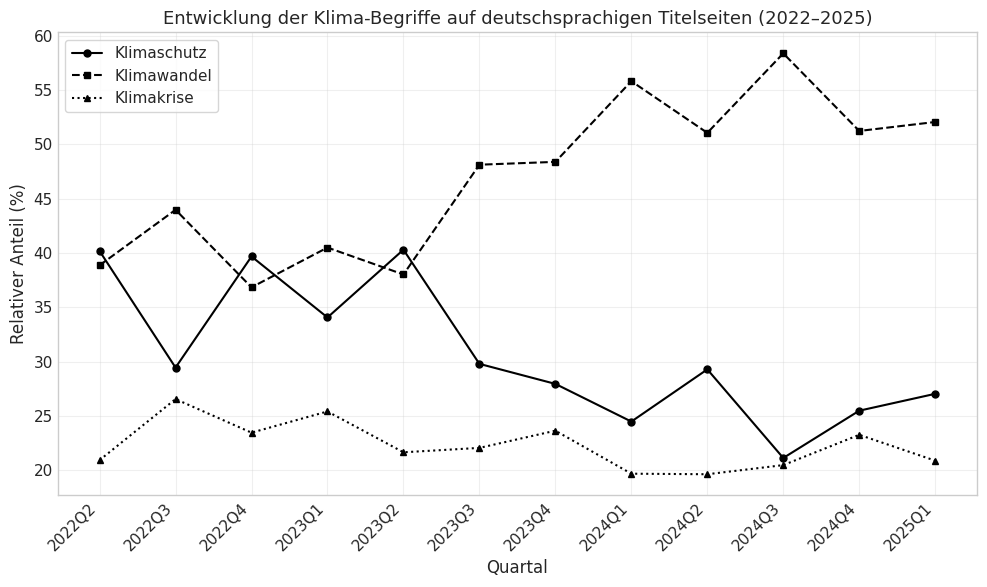

Grafik 1 gespeichert: /home/butburg/repos/wortwandel/code_generated/grafik_1_zeitliche_entwicklung.png


In [9]:
# Daten vorbereiten
quarterly_pct_plot = quarterly_pct.drop(columns=['Gesamt'], errors='ignore')

fig, ax = plt.subplots(figsize=(10, 6))

# Linienarten definieren (schwarz-weiß tauglich)
linestyles = {'Klimaschutz': '-', 'Klimawandel': '--', 'Klimakrise': ':'}
markers = {'Klimaschutz': 'o', 'Klimawandel': 's', 'Klimakrise': '^'}

for begriff in ['Klimaschutz', 'Klimawandel', 'Klimakrise']:
    if begriff in quarterly_pct_plot.columns:
        ax.plot(
            range(len(quarterly_pct_plot)),
            quarterly_pct_plot[begriff],
            linestyle=linestyles[begriff],
            marker=markers[begriff],
            color='black',
            linewidth=1.5,
            markersize=5,
            label=begriff
        )

# X-Achsen-Labels
ax.set_xticks(range(len(quarterly_pct_plot)))
ax.set_xticklabels([str(q) for q in quarterly_pct_plot.index], rotation=45, ha='right')

ax.set_xlabel('Quartal')
ax.set_ylabel('Relativer Anteil (%)')
ax.set_title('Entwicklung der Klima-Begriffe auf deutschsprachigen Titelseiten (2022–2025)')
ax.legend(loc='best', frameon=True)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'grafik_1_zeitliche_entwicklung.png'), dpi=300, bbox_inches='tight')
plt.show()
print(f"Grafik 1 gespeichert: {os.path.join(OUTPUT_PATH, 'grafik_1_zeitliche_entwicklung.png')}")

### Grafik 2a: Neutral vs. Alarmistisch (Flächendiagramm)

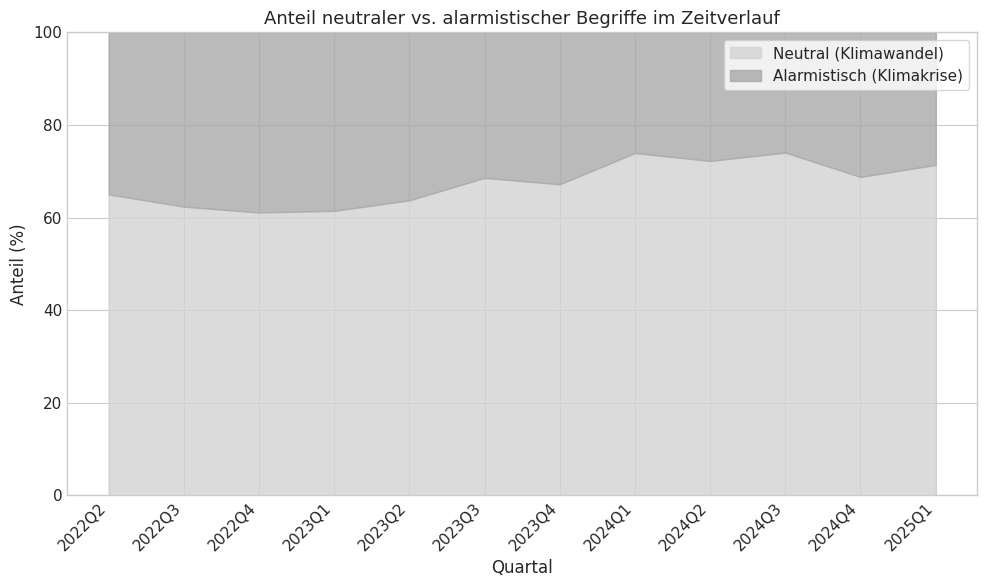

Grafik 2a gespeichert: /home/butburg/repos/wortwandel/code_generated/grafik_2a_neutral_vs_alarmistisch_flaeche.png


In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

# Flächendiagramm mit Grautönen
x = range(len(neutral_alarm_pct))

ax.fill_between(x, 0, neutral_alarm_pct['Neutral'],
                color='lightgray', label='Neutral (Klimawandel)', alpha=0.8)
ax.fill_between(x, neutral_alarm_pct['Neutral'], 100,
                color='darkgray', label='Alarmistisch (Klimakrise)', alpha=0.8)

# X-Achsen-Labels
ax.set_xticks(x)
ax.set_xticklabels([str(q) for q in neutral_alarm_pct.index], rotation=45, ha='right')

ax.set_xlabel('Quartal')
ax.set_ylabel('Anteil (%)')
ax.set_title('Anteil neutraler vs. alarmistischer Begriffe im Zeitverlauf')
ax.legend(loc='upper right', frameon=True)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'grafik_2a_neutral_vs_alarmistisch_flaeche.png'), dpi=300, bbox_inches='tight')
plt.show()
print(f"Grafik 2a gespeichert: {os.path.join(OUTPUT_PATH, 'grafik_2a_neutral_vs_alarmistisch_flaeche.png')}")

### Grafik 2b: Neutral vs. Alarmistisch (Liniendiagramm)

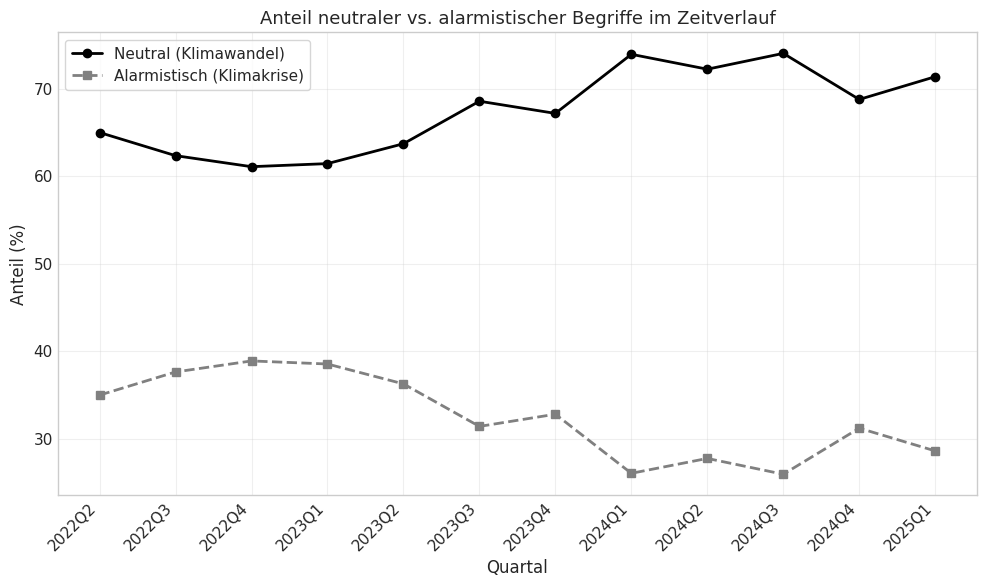

Grafik 2b gespeichert: /home/butburg/repos/wortwandel/code_generated/grafik_2b_neutral_vs_alarmistisch_linien.png


In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

x = range(len(neutral_alarm_pct))

ax.plot(x, neutral_alarm_pct['Neutral'],
        linestyle='-', marker='o', color='black', linewidth=2,
        label='Neutral (Klimawandel)')
ax.plot(x, neutral_alarm_pct['Alarmistisch'],
        linestyle='--', marker='s', color='gray', linewidth=2,
        label='Alarmistisch (Klimakrise)')

# X-Achsen-Labels
ax.set_xticks(x)
ax.set_xticklabels([str(q) for q in neutral_alarm_pct.index], rotation=45, ha='right')

ax.set_xlabel('Quartal')
ax.set_ylabel('Anteil (%)')
ax.set_title('Anteil neutraler vs. alarmistischer Begriffe im Zeitverlauf')
ax.legend(loc='best', frameon=True)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'grafik_2b_neutral_vs_alarmistisch_linien.png'), dpi=300, bbox_inches='tight')
plt.show()
print(f"Grafik 2b gespeichert: {os.path.join(OUTPUT_PATH, 'grafik_2b_neutral_vs_alarmistisch_linien.png')}")

### Grafik 3: Absolute Häufigkeiten (Balkendiagramm)

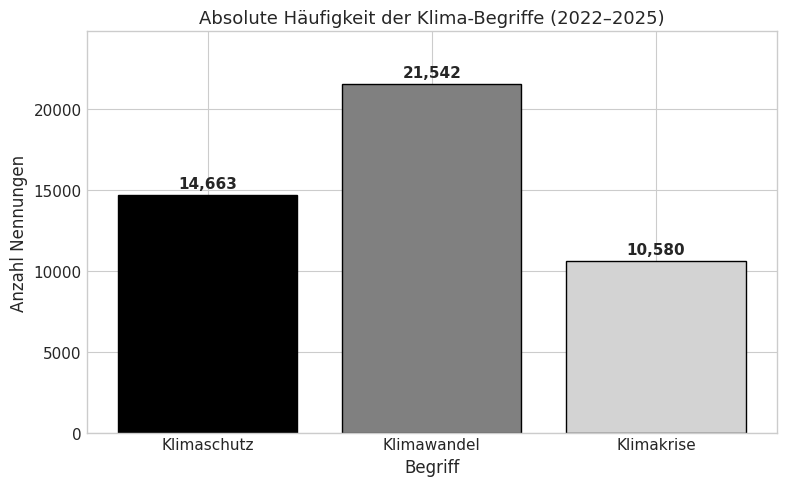

Grafik 3 gespeichert: /home/butburg/repos/wortwandel/code_generated/grafik_3_absolute_haeufigkeiten.png


In [12]:
fig, ax = plt.subplots(figsize=(8, 5))

# Daten
begriffe = ['Klimaschutz', 'Klimawandel', 'Klimakrise']
counts_sorted = [counts.get(b, 0) for b in begriffe]

# Balken mit Grautönen
colors = ['black', 'gray', 'lightgray']
bars = ax.bar(begriffe, counts_sorted, color=colors, edgecolor='black')

# Werte über Balken anzeigen
for bar, count in zip(bars, counts_sorted):
    ax.annotate(f'{count:,}',
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, 5), textcoords='offset points',
                ha='center', fontsize=11, fontweight='bold')

ax.set_xlabel('Begriff')
ax.set_ylabel('Anzahl Nennungen')
ax.set_title('Absolute Häufigkeit der Klima-Begriffe (2022–2025)')
ax.set_ylim(0, max(counts_sorted) * 1.15)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'grafik_3_absolute_haeufigkeiten.png'), dpi=300, bbox_inches='tight')
plt.show()
print(f"Grafik 3 gespeichert: {os.path.join(OUTPUT_PATH, 'grafik_3_absolute_haeufigkeiten.png')}")

---
## Erkenntnisse

Die konkreten Zahlen werden nach Ausführung des Notebooks hier zusammengefasst.

In [13]:
# Zusammenfassung der wichtigsten Zahlen
print("\n" + "="*60)
print("ZUSAMMENFASSUNG DER ERGEBNISSE")
print("="*60)

print(f"\n📊 GESAMTZAHLEN (ab 21.04.2022)")
print(f"   Gesamtzahl Nennungen: {total:,}")
for b in begriffe:
    c = counts.get(b, 0)
    p = (c / total * 100)
    print(f"   {b}: {c:,} ({p:.1f}%)")

print(f"\n📈 ZEITLICHE ENTWICKLUNG (erstes vs. letztes Quartal)")
first_q = quarterly_pct_plot.iloc[0]
last_q = quarterly_pct_plot.iloc[-1]
for b in begriffe:
    if b in first_q.index:
        diff = last_q[b] - first_q[b]
        trend = '↑' if diff > 0 else '↓' if diff < 0 else '→'
        print(f"   {b}: {first_q[b]:.1f}% → {last_q[b]:.1f}% ({trend} {abs(diff):.1f} Pp.)")

print(f"\n⚖️ NEUTRAL VS. ALARMISTISCH")
first_na = neutral_alarm_pct.iloc[0]
last_na = neutral_alarm_pct.iloc[-1]
print(f"   Erstes Quartal: Neutral {first_na['Neutral']:.1f}% | Alarmistisch {first_na['Alarmistisch']:.1f}%")
print(f"   Letztes Quartal: Neutral {last_na['Neutral']:.1f}% | Alarmistisch {last_na['Alarmistisch']:.1f}%")

print("\n" + "="*60)


ZUSAMMENFASSUNG DER ERGEBNISSE

📊 GESAMTZAHLEN (ab 21.04.2022)
   Gesamtzahl Nennungen: 46,785
   Klimaschutz: 14,663 (31.3%)
   Klimawandel: 21,542 (46.0%)
   Klimakrise: 10,580 (22.6%)

📈 ZEITLICHE ENTWICKLUNG (erstes vs. letztes Quartal)
   Klimaschutz: 40.2% → 27.0% (↓ 13.1 Pp.)
   Klimawandel: 38.9% → 52.1% (↑ 13.2 Pp.)
   Klimakrise: 20.9% → 20.9% (↓ 0.0 Pp.)

⚖️ NEUTRAL VS. ALARMISTISCH
   Erstes Quartal: Neutral 65.0% | Alarmistisch 35.0%
   Letztes Quartal: Neutral 71.4% | Alarmistisch 28.6%

